In [16]:
import numpy as np
import pandas as pd
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras import regularizers

In [17]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
# np.savez('fishing.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
#https://github.com/ioskn/mldl_htwg/raw/master/data/fishing.npz
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')
X_train = d['Xt'] #"livebait","camper","persons","child"
X_test = d['Xte']
y_train = d['yt']
y_test = d['yte']
pd.DataFrame(X_train[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


In [18]:
tfd = tfp.distributions

inputs = Input(shape=(X_train.shape[1],))
model = Dense(1, activation=tf.exp, kernel_regularizer=regularizers.l2(0.001))(inputs)
model = tfp.layers.DistributionLambda(tfd.Poisson)(model)

model_p = Model(inputs=inputs, outputs=model)

def NLL(y_true, y_hat):
  return -y_hat.log_prob(y_true)

model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
 distribution_lambda_4 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=1000)

Epoch 1/1000
7/7 [==============================] - 1s 36ms/step - loss: 5.7820 - val_loss: 5.1786
Epoch 2/1000
7/7 [==============================] - 0s 8ms/step - loss: 4.8325 - val_loss: 4.6182
Epoch 3/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.4886 - val_loss: 4.4757
Epoch 4/1000
7/7 [==============================] - 0s 8ms/step - loss: 4.4747 - val_loss: 4.4282
Epoch 5/1000
7/7 [==============================] - 0s 9ms/step - loss: 4.4770 - val_loss: 4.3894
Epoch 6/1000
7/7 [==============================] - 0s 8ms/step - loss: 4.4612 - val_loss: 4.3546
Epoch 7/1000
7/7 [==============================] - 0s 8ms/step - loss: 4.4338 - val_loss: 4.2998
Epoch 8/1000
7/7 [==============================] - 0s 8ms/step - loss: 4.3634 - val_loss: 4.2456
Epoch 9/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.3239 - val_loss: 4.2013
Epoch 10/1000
7/7 [==============================] - 0s 8ms/step - loss: 4.2697 - val_loss: 4.1589
Epoch 11/1000
7/7 

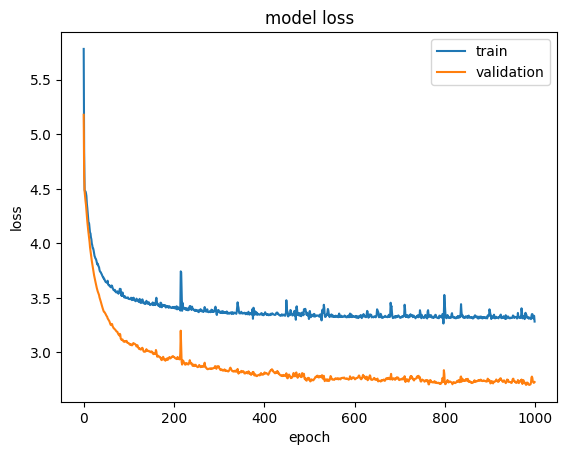

In [20]:
plt.style.use('default')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [23]:
model2 = Model(inputs=inputs, outputs=model)
prediction = model2.predict(X_test).flatten()

rmse=np.sqrt(np.mean((y_test - prediction)**2))
mae=np.mean(np.abs(y_test - prediction))
NLL = model_p.evaluate(X_test, y_test)

print("RMSE:", rmse)
print("MAE: ", mae)
print("NLL: ", NLL)

2/2 [==============================] - 0s 3ms/step - loss: 2.7291
RMSE: 7.5006666
MAE:  3.26
NLL:  2.7290518283843994


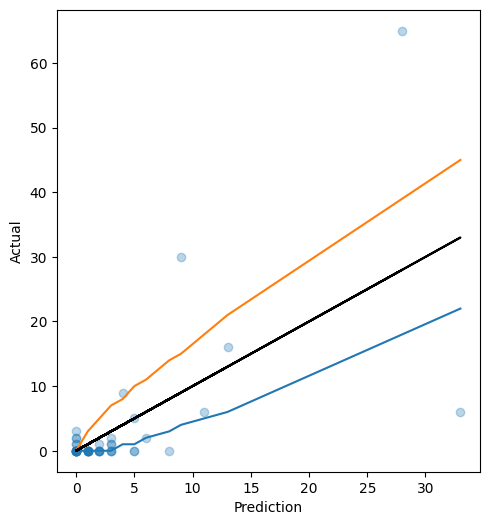

In [28]:
from scipy.stats import poisson
lower=poisson.ppf(0.025, prediction)
upper=poisson.ppf(0.975, prediction)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(prediction, y_test, alpha=0.3)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.plot(prediction[np.argsort(prediction,axis=0)].flatten(), lower[np.argsort(prediction,axis=0)])
plt.plot(prediction[np.argsort(prediction,axis=0)].flatten(), upper[np.argsort(prediction,axis=0)])
plt.plot(prediction, prediction, c="black")